<h1>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</h1>
<p>This notebook enables to replicate the methods described in: Giovanelli, R.,Traviglia, A., 2023. <i>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</i>.</p>

<h2>Web Harvesting</h2>

In [1]:
from datetime import datetime
import time
import json
import logging
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx

from setup.config import PLOTS_FOLDER, GRAPH_FOLDER, DATASET_FOLDER, MERGES, EXCEPTIONSEQUAL, EXCEPTIONSIN
from src.utils.utils import saveJson, openJson, format_time, pR
from src.utils.harvesting import collect_sales, collect_sales_sothebys, collectPAA
from src.utils.mapping import remap_christies_data, map_sothebys_data, remap_paa_data, cleanSubdictionaries, hashAndClean
from src.utils.cleaning import cleanNeo, run_cypher_query, generalQuery, nodes_and_edges, remove_nodes_by_regex_and_label, changeLabel, mergingNodes, removeErrArtwork, mergingDuples, merge_nodes_same_name
from src.utils.statistical_analysis import plot_bar_chart, countLabelsData, read_centrality_data, find_common_nodes, statistics_graph, barDegree
from src.utils.similarity import similarityCheckRemoval, checkManual, find_similar_nodes, removePatterns

now = datetime.now()
date_and_hour = datetime.now().strftime("%d%m%Y_%H%M")

<h3>Christie's WA</h3>
In the input, insert the first year from wich to start the collection, and the last year. Before 1998 there are no data.</br>
Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</br>
The estimated time for storing data of a sale with around 80 objects and no images is 59 sec on a CPU.</br></p>

In [ ]:
start_year = int(input("Please, input the year from which to start scraping"))
end_year = int(input("Please, input the last year from which you want to scrape")) + 1
storingImage_christies = input("Do you want to store images? Y or N").lower()
if storingImage_christies == 'y':
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=True)
else:
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=False)

<h3>Sotheby's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>


In [ ]:
with open('auctionIds_sotheby.json','r',encoding='utf-8') as file:
    auctionIds_sotheby = json.load(file)
storingImage_sothebys = input("Do you want to store images? Y or N").lower()
if storingImage_sothebys == 'y':
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=True)
else:
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=False)

<h3>Phoenix Ancient Art's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>

In [ ]:
storingImage_paa = input("Do you want to store images? Y or N").lower()
if storingImage_paa == 'y':
    antiquities_paa = collectPAA(storeImage=True)
else:
    antiquities_paa = collectPAA(storeImage=False)

<h2>Ontology mapping and Knowledge Graph database building</h2>

<h3>Ontology mapping</h3>
<p>The following cells will reload the datasets you stored from the previous cells and remap the datasets toward a single cleaned and postprocessed datasets, with only the relevant key-values pairs and a common taxonomy</p>

In [ ]:

christies_data = openJson('christies_raw.json')
sothebys_data = openJson('sothebys_raw.json')
paa_data = openJson('paa_raw.json')
start_time = time.time()
logging.basicConfig(filename='error_log.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# Map Christie's data to the final keys
final_christies_data = remap_christies_data(christies_data)
# Map Sotheby's data to the final keys
final_sothebys_data = map_sothebys_data(sothebys_data)
# Map PAA's data to the final keys
final_paa_data = remap_paa_data(paa_data)

# Combine datasets into a single list
partial_output = final_sothebys_data + final_christies_data + final_paa_data

# Hash and Reorder json file
final_output = cleanSubdictionaries(partial_output)
db = hashAndClean(final_output)

end_time = time.time()
execution_time = end_time - start_time

In [29]:
print(f"The remapping and cleaning of the original datasets in a single one took {format_time(70.18606495857239)} to complete with:\n1269.95 it/s for Christie's\n2.98it/s for Sotheby's\n14961.61it/s for PAA")

The remapping and cleaning of the original datasets in a single one took 01:10 minutes to complete with:
1269.95 it/s for Christie's
2.98it/s for Sotheby's
14961.61it/s for PAA


The following cell will save in a .json file inside datasets folder the complete data

In [7]:
os.makedirs(DATASET_FOLDER, exist_ok=True)
saveJson(db,f'{DATASET_FOLDER}db.json')

The following cell will reload the completa data file

<h3>Knowledge Graph database building</h3>
The following cells will generate a Neo4j Knowledge Graph from the .json dataset, extracting events from the provenance statements as collected and refactoring them into separate entities such as actors, dates, locations.</br>
Before running the following cells make sure to follow the Neo4j installation guidelines.</br>
<p>
<b>Neo4j Installation and setup</b></br>
Install Neo4J Desktop from <a href='https://neo4j.com/deployment-center/'> here </a> chosing the right os.</br>
<img src="imgs/n4jdsk.png" width='630'> </br>
Follow along the guide from Neo4j documentation <a href='https://neo4j.com/docs/desktop-manual/current/'>here</a>.</br>
When you first database is created, as described <a href='https://neo4j.com/docs/desktop-manual/current/operations/create-dbms/'>here</a>, you will need to adjust the configuration inside the <a href='setup/config.py'>config.py</a> file under 'setup' folder in this project, changing the uri and the password according to your Neo4j Desktop configurations. The default localhost and username are the following, the password is set by you upon creating your first database instance.

</p>
<p>
neo4j = {</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"uri":"bolt://localhost:7687",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"username": "neo4j",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"password": "admininstrator",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"encrypted": False</br>
}</br>
</p>
<p>When both Neo4j Desktop and the config file are set, click "Start" to start the Neo4j Database instance and then "Open".</p>
<p><img src='imgs/kgopen.png' width='630'></p>
<p></p>
<p><img src='imgs/kgstart.png' width='630'></p>
<p>This will open in a new window an empty database.</br>
<img src='imgs/newdb.png' width = '630'></br>
Making sure our database is <b>active</b>, we can procede and run the following cells.</p>

<h3> Event Extraction </h3>
The following cells will use event_extraction.py to analyse and split each provenance statement found in the raw data into different <i>events</i>. Each event ideally contains an actor, a location, and a time-span indication.
For testing, we utilise NER models of different languages from Spacy library. The output 'events/events.txt' will contain for each artwork the labeled entities found in each separated provenance event. </br>
The estimated time for extracting events from 39103 objects is 64 minutes on a CPU (nearly 10 objects/s)</br>

In [8]:
data = openJson(f'{DATASET_FOLDER}db.json')

529 30422


In [ ]:
from batch_detector import *
__name__ = "__main__"
start_time = time.time()
if __name__ == '__main__':
    main()
end_time = time.time()
execution_time = end_time-start_time

In [27]:
print(f'The batch process to detect language for each provenance statement took {format_time(execution_time)}')

The batch process to detect language for each provenance statement took 14:14 minutes


In [11]:
print(f"Events: {len(data['events'])}")
print(f"Artworks: {len(data['lots'])}")
print(f"Sources: 3")
print(f"Total entries: {len(data['events'])+len(data['lots'])+3}")

Events: 529
Artworks: 30422
Sources: 3
Total entries: 30954


In [12]:
data_lang = openJson(f"{DATASET_FOLDER}lang_db.json")
data['lots'] = data_lang['lots']
saveJson(data,f"{DATASET_FOLDER}final_db.json")

In [ ]:
from event_extraction import *
start_time = time.time()
if __name__ == "__main__":  
    file=openJson(f'{DATASET_FOLDER}final_db.json')    
    artworks = list(file['lots'].values())
    artwork_index = batch_extract_store_events(artworks, batch_size=50)            
    print("Job done")    
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
print(f'The NAMED ENTITY RECOGNITION process and generation of events took {format_time(execution_time)}')

In [2]:
#check for duplicates based on lotHash
data = duplicatesCheck("events/events.txt")

Length of data: 30422
Length of unique_entries: 30422
Duplicates removed: 0


<h3>Neo4j KG Databae Population</h3>
The following code will populate the Neo4j database with the original nodes of artworks and events connected to the corresponding artworks through a (a:artwork)-[r:PARTICIPATED_TO_EVENT]->(b:event) relationship.</br>
In this way, each event involving a specific object is automatically linked to the respective entities represented within it.</br>
Autonomous CYPHER queries refactor the events according to the ontology schema: the event node remains central, receiving relationships from the artworks and projecting or receiving new relationships to other entities automatically generated by Spacy and refactored based on our ontology.</br>
The estimated time for building and refactoring the Neo4j KG Database is  minutes on a CPU.</br>

In [4]:
__name__ = "__main__"
from kg_construction import *
start_time = time.time()
if __name__ == "__main__":
    main()
end_time = time.time()
execution_time = end_time - start_time

  0%|          | 0/30422 [00:00<?, ?it/s]

starting extraction of new entities from events
merging double rels


In [5]:
print(f'The Knwoledge Graph creation took {format_time(end_time - start_time)}')

The Knwoledge Graph creation took 2:56:35 hours


<h1>Preliminary Results</h1>

<h2>First Graph data</h2>
The following cells, that must be played with the Neo4j database active, will output the graph displaying number of nodes x label and number of relationships x type

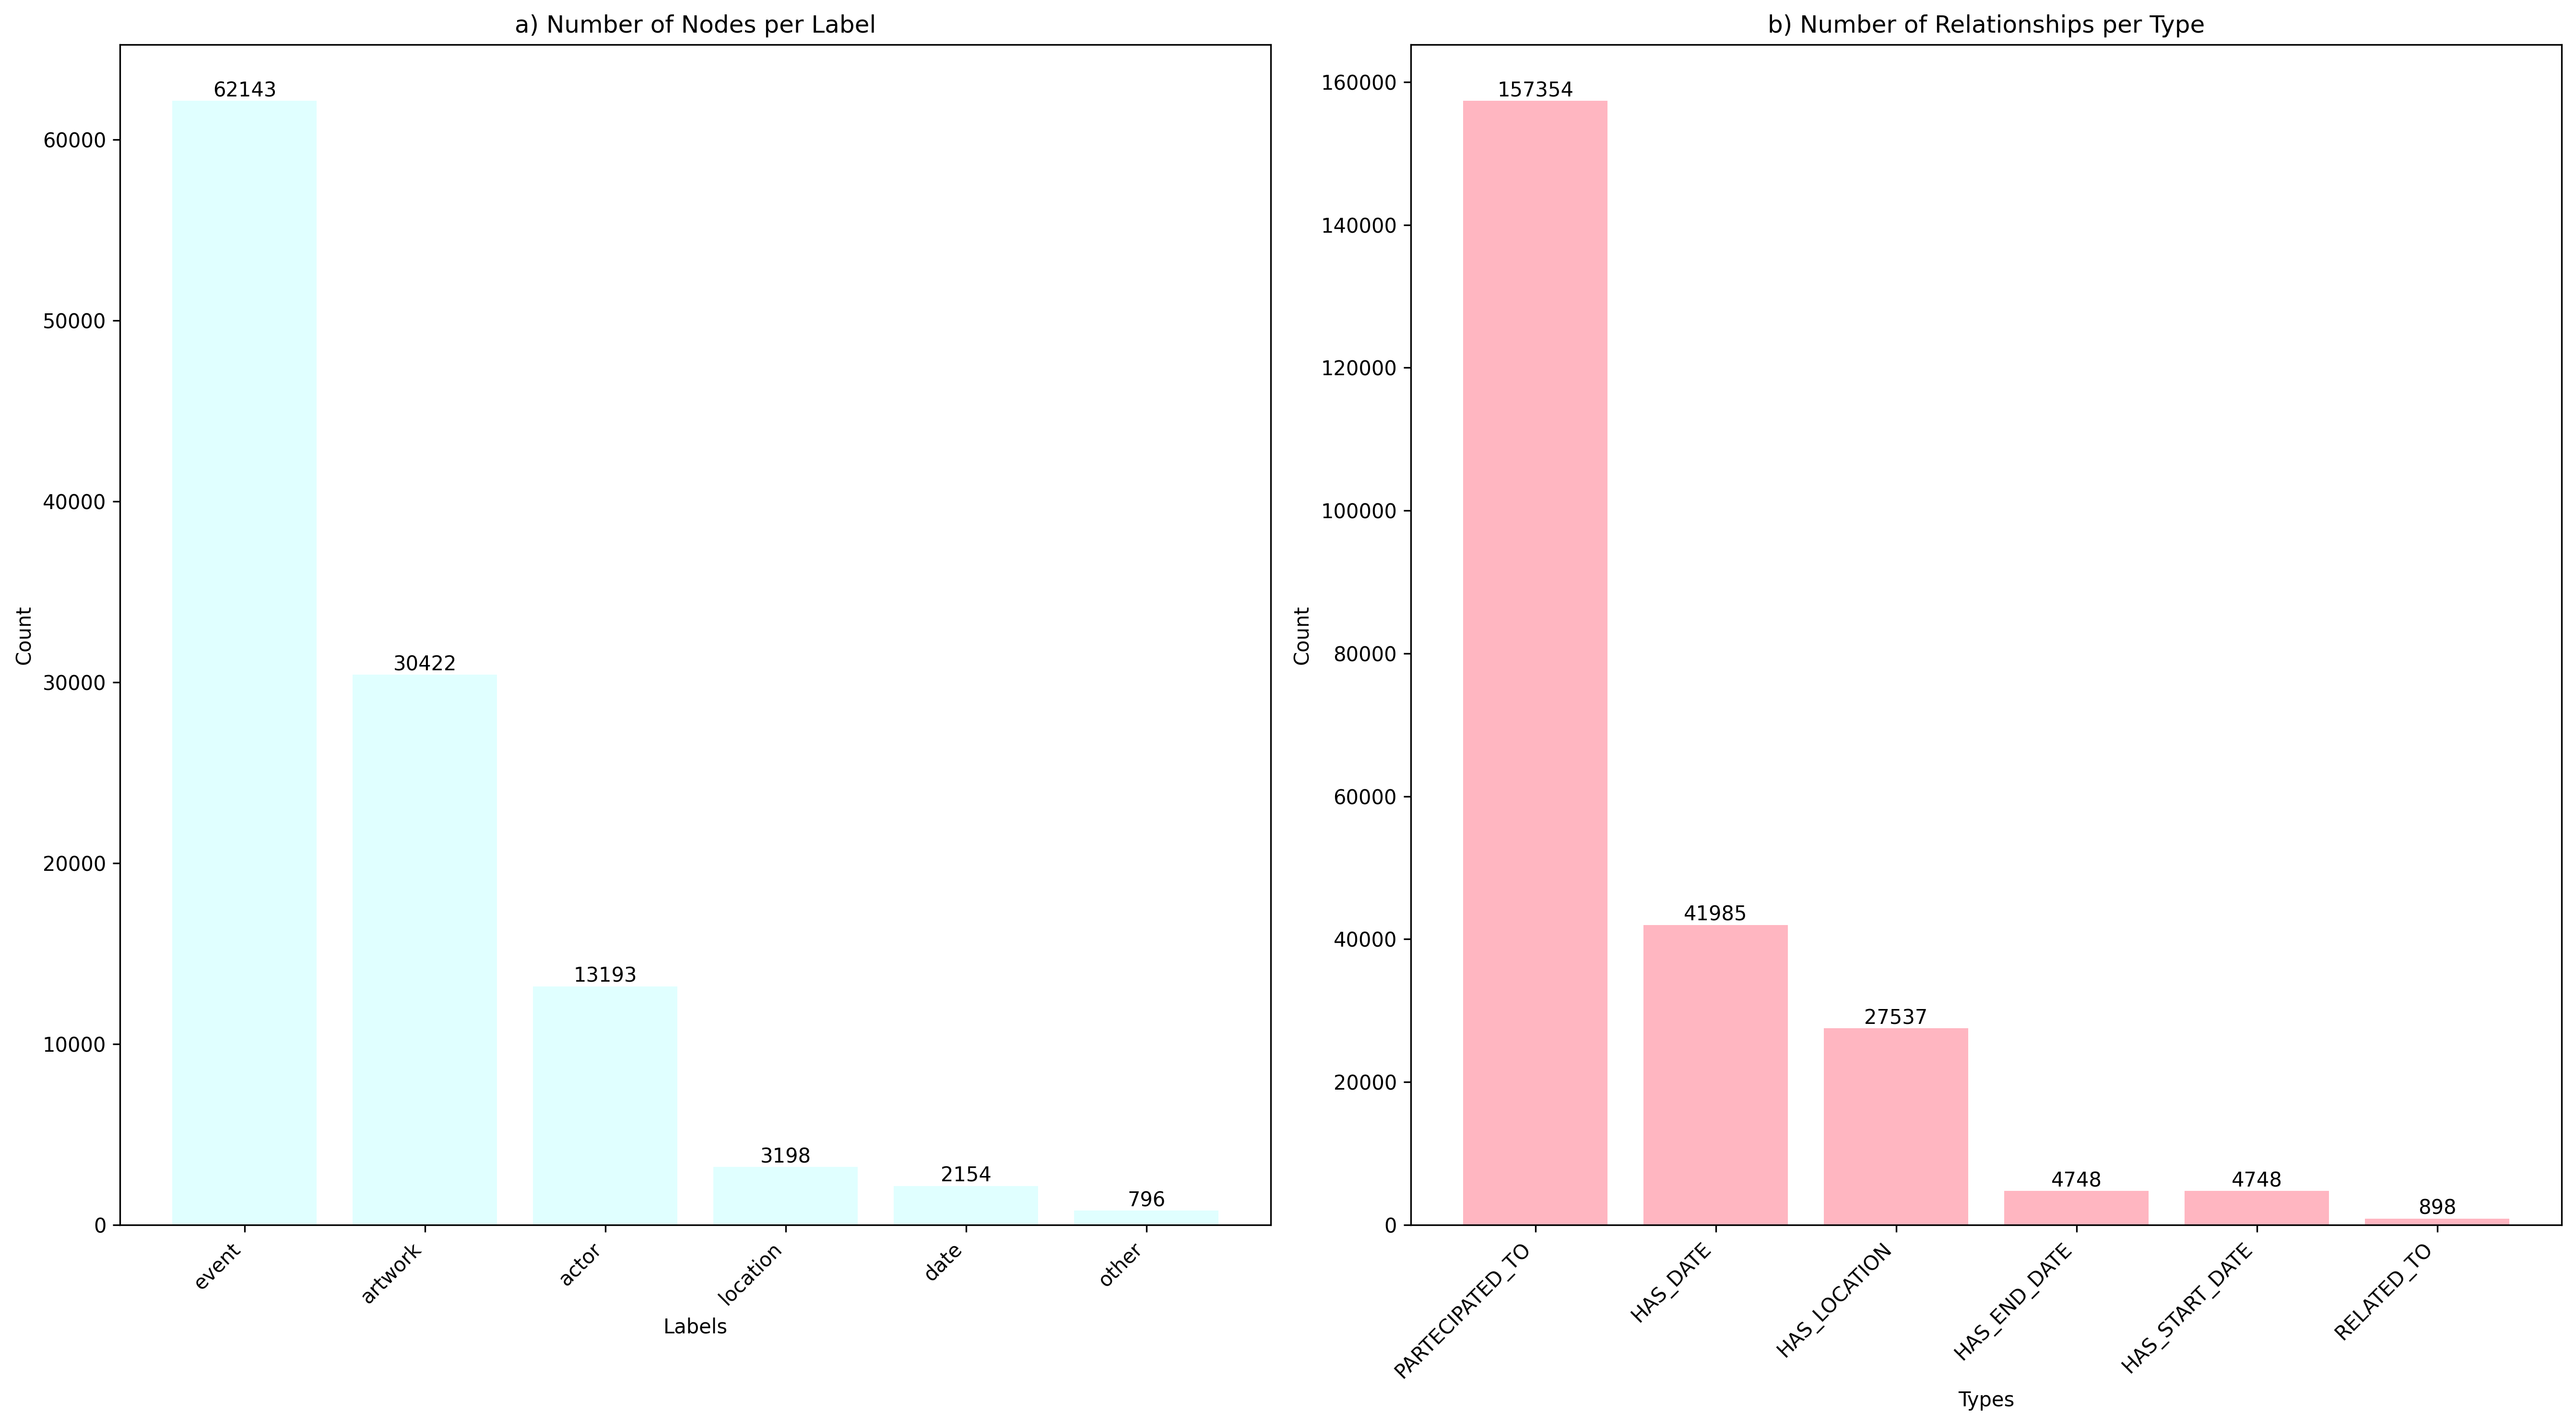

In [4]:
cleanNeo()
# Execute a query to get the number of nodes for each label
node_labels_query = "MATCH (n) RETURN labels(n) as labels, count(n) as count"
node_labels_result = run_cypher_query(node_labels_query,calctime=True)

# Execute a query to get the number of relationships for each type
relationship_types_query = "MATCH ()-[r]->() RETURN type(r) as type, count(r) as count"
relationship_types_result = run_cypher_query(relationship_types_query,calctime=True)

# Plot number of nodes for each label
node_labels_data = {}
for result in node_labels_result:
    labels = result.value('labels')
    count = result.value('count')
    for label in labels:
        if label in node_labels_data:
            node_labels_data[label] += count
        else:
            node_labels_data[label] = count

# Plot number of relationships for each type
relationship_types_data = {}
for result in relationship_types_result:
    relationship_type = result.value('type')
    count = result.value('count')
    relationship_types_data[relationship_type] = count

os.makedirs(PLOT_FOLDER, exist_ok=True)
file_name = 'combined_bar_charts.png' #change here the file name if needed

plt.figure(figsize=(18, 10), dpi=300)

plt.subplot(1, 2, 1)
plot_bar_chart(node_labels_data, 'a) Number of Nodes per Label', 'Labels', 'Count', color='lightcyan', label_rotation=True)

plt.subplot(1, 2, 2)
plot_bar_chart(relationship_types_data, 'b) Number of Relationships per Type', 'Types', 'Count', color='lightpink', label_rotation=True)

plt.subplots_adjust(right=0.85)  # Increase the margin on the right side
plt.tight_layout()
plt.savefig(f'{PLOT_FOLDER}{file_name}', dpi=300) #change dpi accordingly
plt.show()

<h2>First Projection: from Knowledge Graph to bipartite Graph</h2>

With the following cell we connect to our Neo4j database and collect artworks, events and actors nodes with their relationsip. Also this cell is to be played with the Neo4j database active.
We then create a netwokx graph directly in python to perform transformation directly on the notebook.

In [ ]:
query = "MATCH (n:artwork)-[r]-(e:event)-[r2]-(a:actor) RETURN *"
result = generalQuery(query)

G = nx.Graph()

for record in tqdm(result):
    artwork_node = record["n"]
    artwork_id = artwork_node['artwork_id']
    event_node = record["e"]
    event_id = event_node['event_id']
    actor_node = record["a"]
    actor_id = dict_hash(dict(actor_node))
    relationship_1 = record["r"]
    relationship_2 = record["r2"]

    # Add nodes and edges to the NetworkX graph
    G.add_node(artwork_id, label='artwork', properties=artwork_node._properties)    
    G.add_node(event_id, label="event", properties=event_node._properties)
    G.add_node(actor_id, label="actor", properties=actor_node._properties)
    G.nodes[actor_id]['actor_id'] = actor_id
    G.add_edge(artwork_id, event_id, label=relationship_1.type, direction='forward')
    G.add_edge(event_id, actor_id, label=relationship_2.type, direction='reverse')

nodes_and_edges(G)
countLabelsData(G)

os.makedirs(GRAPH_FOLDER, exist_ok=True)
graph_pickle = 'initial_graph.pickle'
# save graph object to file
pickle.dump(G, open(f'{GRAPH_FOLDER}{graph_pickle}', 'wb'))

In [34]:
# load graph object from file
G = pickle.load(open(f'{GRAPH_FOLDER}{graph_pickle}', 'rb'))

Nodes: 94845
Edges: 124348


(94845, 124348)

Once we collected the nodes that we need, we actually refactor our graph transforming each event to which both an artwork and a actor participated into a directed relationship (actor)-[:DEALT_WITH]->(artwork).  

In [35]:
from pyvis.network import Network
# Create a copy of the original graph
subgraph = G.copy()

# List to store nodes to be removed
nodes_to_remove = []

# Identify and remove event nodes
for node in tqdm(list(subgraph.nodes()), desc='Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors'):
    if subgraph.nodes[node]['label'] == 'event':
        # Find connected actor and artwork nodes
        neighbors = list(subgraph.neighbors(node))
        actor_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'actor']
        artwork_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'artwork']
        
        # Add the actor-artwork relationships
        for actor in actor_nodes:
            for artwork in artwork_nodes:
                subgraph.add_edge(actor, artwork, label='dealt_with', direction='forward')
        
        # Add the event node to nodes_to_remove list
        nodes_to_remove.append(node)

# Remove the nodes
subgraph.remove_nodes_from(nodes_to_remove)
nodes,edges = nodes_and_edges(subgraph)

# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
subgraph_pickle = 'actor_artworks.pickle'
countLabelsData(subgraph)
pickle.dump(subgraph, open(f'{GRAPH_FOLDER}{subgraph_pickle}', 'wb'))

Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors:   0%|          | 0/94845 [00:00<?, ?it/s]

Nodes: 43425
Edges: 71037


Setting titles:   0%|          | 0/43425 [00:00<?, ?it/s]

<h2>Cleaning of duplicate names</h2>

The following cells will leverage similarity.py

In [ ]:
removePatterns(subgraph) #this function will replace specific patterns with empty strings, in order to reduce the complexity of the string 

print('Merging Identical Names')
count = 0
for name in tqdm([subgraph.nodes[node]['properties']['name'] for node in subgraph.nodes if subgraph.nodes[node]['label']=='actor']):
    _,count = merge_nodes_same_name(subgraph,name, count)
print(f'Nodes merged: {count}')
print('')

print('Calculating Similar Nodes')
similar_nodes, mergesraw = find_similar_nodes(subgraph, merges, threshold=0.93)
for node1, node2, similarity in similar_nodes:
    print(f"Nodes {subgraph.nodes[node1]['properties']['name']} and {subgraph.nodes[node2]['properties']['name']} are similar with similarity {similarity:.2f}")
print('')

In [37]:
print(f'Nodes merged: {count}')
pickle.dump(similar_nodes, open(f'{DATASET_FOLDER}similar_nodes.pickle', 'wb'))
pickle.dump(mergesraw, open(f'{DATASET_FOLDER}mergesraw.pickle', 'wb'))
pickle.dump(subgraph, open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))

Nodes merged: 687


In [ ]:
similar_nodes = pickle.load(open(f'{DATASET_FOLDER}similar_nodes.pickle','rb'))
mergeswaw = pickle.load(open(f'{DATASET_FOLDER}mergesraw.pickle'))
subgraph = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))
excls, count = similarityCheckRemoval(similar_nodes,subgraph)

In [39]:
print('Nodes merged:',count)

Nodes merged: 98


In [ ]:
#process some merge based on some manually checked names
sub, merges = checkManual(mergesraw,subgraph)
pickle.dump(sub,open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))
print('Nodes merged:',count)

In [ ]:
sub = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))

The following cells will clean the data

In [42]:
#remove nodes that are entities recognition mistakes 
print('Graph before processing:')
nodes_and_edges(sub)
countLabelsData(sub)
remove_nodes_by_regex_and_label(sub)
count = changeLabel(sub)
mergingDuples(sub)
sub,count = mergingNodes(sub,MERGINGS)
removeErrArtwork(sub)
print('Graph after processing:')
nodes_and_edges(sub)
countLabelsData(sub)
pickle.dump(sub,open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','wb'))

The following cell will set a title on each node with its name and node id for eventual visualisation and display the bar chart with the top 20 highest degree nodes.

Sotheby's Degree -> 19850
Christie's Degree -> 11587
the Tuyet Nguyet Degree -> 656
Wou Kiuan Degree -> 273
Daniel Cordier Collection Degree -> 253
N Koutoulakis Degree -> 211
Collection Mrs Degree -> 205
the Junkunc Collection Degree -> 185
European private collection Degree -> 159
Charles Ede Degree -> 147
Hôtel Drouot Degree -> 135
Royal Athena Degree -> 135
Sotheby Parke-Bernet Degree -> 133
Edric van Vredenburgh Degree -> 119
PROPERTY FROM A SWISS PRIVATE COLLECTION Degree -> 99
Plesch Degree -> 98
PROPERTY FROM A MANHATTAN PRIVATE COLLECTION Degree -> 98
Rudolf Schmidt Degree -> 94
E Borowski Degree -> 90
The Groppi Collection Degree -> 87


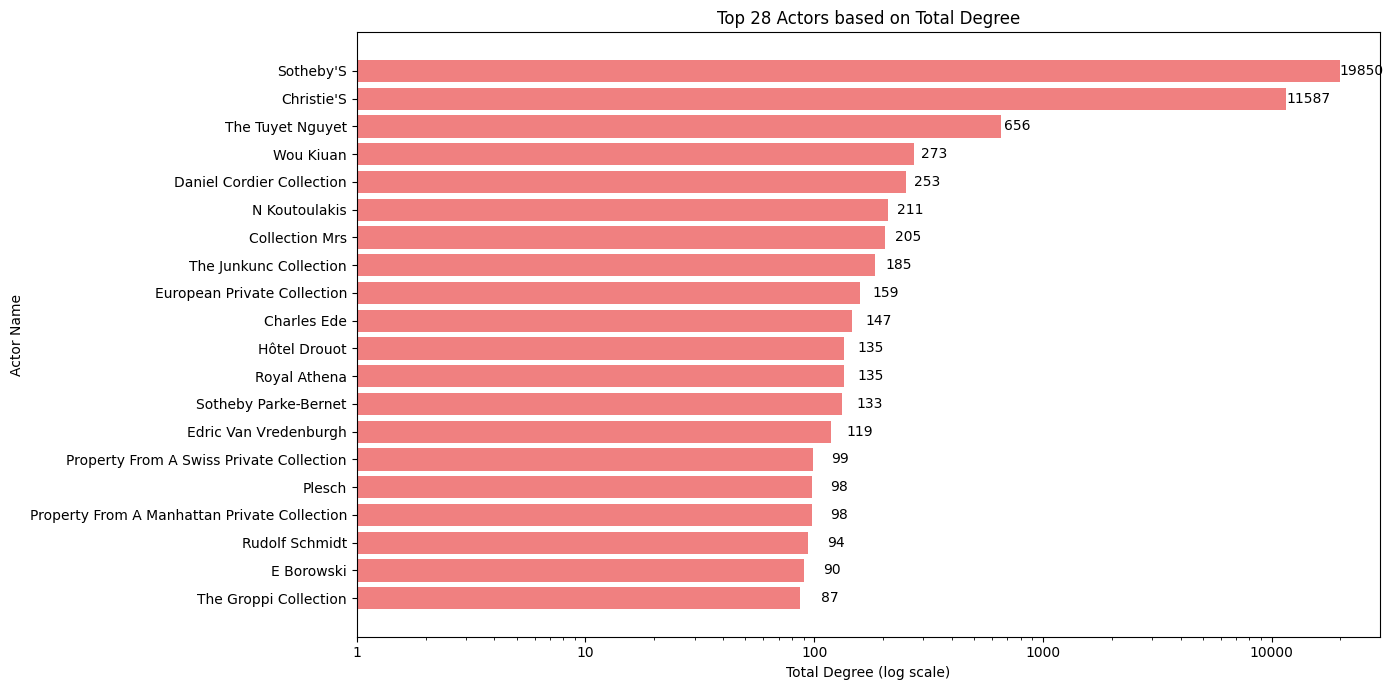

In [42]:
sub = pickle.load(open(f'{GRAPH_FOLDER}{subgraph_pickle}_clean.pickle','rb'))
for node in tqdm(sub.nodes(), desc='Setting titles'):
    if sub.nodes[node]['label'] == 'actor':
        name = sub.nodes[node]['properties']['name']
        sub.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif sub.nodes[node]['label'] == 'artwork':
        lotTitle = sub.nodes[node]['properties']['lotTitle']
        sub.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
barDegree(sub,num=20)

<h2>Second Projection: from bipartite to a one-mode undirected weighted graph (actors)-[:SHARES_ARTWORK]-(actors)</h2>

The following cell will operate the projection directly in python

In [43]:
# Create a new directed graph to hold the adjusted edges
actors_actors = nx.DiGraph()
# Sort nodes by degree in descending order
sorted_nodes = sorted(sub.nodes(), key=lambda x: sub.degree(x), reverse=True)
# Create a new undirected subgraph for actor sharing artwork
shared_artwork_subgraph = nx.Graph()
# Create a subgraph excluding the highest degree nodes "Christie's" and "Sotheby's"
subgraph_excluded = sub.subgraph(sorted_nodes[2:])
# Iterate through the 'actor' nodes in the original subgraph
for actor in tqdm(subgraph_excluded.nodes(),desc='Processing nodes'):
    if sub.nodes[actor]['label'] == 'actor':
        # Get the 'artwork' neighbors of the current 'actor'
        actor_neighbors = [neighbor for neighbor in subgraph_excluded.neighbors(actor) if subgraph_excluded.nodes[neighbor]['label'] == 'artwork']
        # Create edges between the 'actor' and 'artwork' neighbors
        for artwork in actor_neighbors:
            shared_actors = [neighbor for neighbor in subgraph_excluded.neighbors(artwork) if neighbor != actor and subgraph_excluded.nodes[neighbor]['label'] == 'actor']
            for shared_actor in shared_actors:
                # Add the start node as 'actor' and the end node as 'actor' in the adjusted graph
                actors_actors.add_node(actor, **subgraph_excluded.nodes[actor])
                actors_actors.add_node(shared_actor, **subgraph_excluded.nodes[shared_actor])
                # Add the edge between actors with weight based on the number of shared artworks
                shared_artworks_count = len([neighbor for neighbor in subgraph_excluded.neighbors(artwork) if subgraph_excluded.nodes[neighbor]['label'] == 'actor'])
                actors_actors.add_edge(actor, shared_actor, weight=shared_artworks_count)

# Convert the directed graph to an undirected graph
actors_actors = actors_actors.to_undirected()
# Find all connected components in the undirected graph
connected_components = list(nx.connected_components(actors_actors))
# Find the largest connected component
largest_connected_component = max(connected_components, key=len)
print(len(largest_connected_component))
# Create a subgraph containing only the largest connected component
largest_subgraph = actors_actors.subgraph(largest_connected_component)
adjusted_graph = largest_subgraph.copy()
nodes_and_edges(adjusted_graph)
countLabelsData(adjusted_graph)
#save largest connected component graph actors->actors
file_name = 'llc_actors_actors'
pickle.dump(adjusted_graph, open(f'{GRAPH_FOLDER}{file_name}.pickle', 'wb'))
nx.write_gexf(adjusted_graph, f"{GRAPH_FOLDER}{file_name}.gexf")

Processing nodes:   0%|          | 0/41509 [00:00<?, ?it/s]

6159


With the following cell we calculate all the relevant measures of the actor-actor connected graph

In [1]:
adjusted_graph = pickle.load(open(f'{GRAPH_FOLDER}llc_actors_actors.pickle', 'rb'))

In [2]:
resulting_values = dict()
if 'Nodes' not in resulting_values:
    node_count = adjusted_graph.number_of_nodes()
    print('Nodes:', node_count)
    resulting_values['Nodes'] = node_count
pR()

if 'Relationships' not in resulting_values:
    num_rels = adjusted_graph.number_of_edges()
    print('Relationships:',num_rels)
    resulting_values['Relationships'] = num_rels
pR()
    
if 'Average Degree (AD)' not in resulting_values:
    # Average Degree
    avg_degree = sum(dict(adjusted_graph.degree()).values()) / node_count
    print("Average Degree (AD):", avg_degree)
    resulting_values['Average Degree (AD)'] = avg_degree
pR()
    
if 'Degree Centrality (DC)' not in resulting_values:
    #Average Degree Centrality
    degree_centrality = nx.degree_centrality(adjusted_graph)
    resulting_values['Degree Centrality (DC)'] = degree_centrality
if 'Average Degree Centrality (ADC)' not in resulting_values:
    average_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    print(f'Average Degree Centrality (ADC): {average_degree_centrality}')
    resulting_values['Average Degree Centrality (ADC)'] = average_degree_centrality
pR()
    
if 'Eigenvector Centrality (EC)' not in resulting_values:
    eigenvector_centrality = nx.eigenvector_centrality(adjusted_graph, weight='weight')
    resulting_values['Eigenvector Centrality (EC)'] = eigenvector_centrality
if 'Average Eigenvector Centrality (AE)' not in resulting_values:
    #Average Eigenvector Centrality
    average_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    print(f'Average Eigenvector Centrality (AE): {average_eigenvector_centrality}')
    resulting_values['Average Eigenvector Centrality (AE)'] = average_eigenvector_centrality
pR()

if 'Betweennes Centrality (BC)' not in resulting_values:
    betweenness_centrality = nx.betweenness_centrality(adjusted_graph,weight='weight')
    resulting_values['Betweenness Centrality (BC)'] = betweenness_centrality
if 'Average Betweenness Centrality (AB)' not in resulting_values:
    average_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    print(f'Average Betweenness Centrality (AB): {average_betweenness_centrality}')
    resulting_values['Average Betweennes Centrality (AB)'] = average_betweenness_centrality
pR()

if 'Closeness Centrality (CC)' not in resulting_values:
    closeness_centrality = nx.closeness_centrality(adjusted_graph)
    resulting_values['Closeness Centrality (CC)'] = closeness_centrality
if 'Average Closeness Centrality (AC)' not in resulting_values:        
    #Average Closeness Centrality
    average_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
    print(f'Average Closeness Centrality (AC): {average_closeness_centrality}')
    resulting_values['Average Closeness Centrality (AC)'] = average_closeness_centrality
pR()

resulting_values = {
    'Nodes': node_count,
    'Relationships': num_rels,
    'Average Degree (AD)': avg_degree,
    'Average Degree Centrality (ADC)': average_degree_centrality,
    'Average Eigenvector Centrality (AE)': average_eigenvector_centrality,
    'Average Betweenness Centrality (AB)': average_betweenness_centrality,
    'Average Closeness Centrality (AC)': average_closeness_centrality,
}

Nodes: 6159
Nodes  :  6159
Relationships: 22390
Relationships  :  22390
Average Degree (AD): 7.2706608215619415
Average Degree (AD)  :  7.2706608215619415
Average Degree Centrality (ADC): 0.0011806854208446793
Average Degree Centrality (ADC)  :  0.0011806854208446793
Average Eigenvector Centrality (AE): 0.0011625709740004026
Average Eigenvector Centrality (AE)  :  0.0011625709740004026
Average Betweenness Centrality (AB): 0.0007339603878900597
Average Betweennes Centrality (AB)  :  0.0007339603878900597
Average Closeness Centrality (AC): 0.21227627664092816
Average Closeness Centrality (AC)  :  0.21227627664092816


In [4]:
if 'Average Path Length (APL)' not in resulting_values:
    # Average Path Length (L)
    avg_path_length = nx.average_shortest_path_length(adjusted_graph)
    print("Average Path Length (APL):", avg_path_length)
    resulting_values['Average Path Length (APL)'] = avg_path_length
pR()

if 'Average Clustering Coefficient (ACC)' not in resulting_values:        
    # Average Clustering Coefficient (C)
    avg_clustering_coefficient = nx.average_clustering(adjusted_graph)
    print("Average Clustering Coefficient (ACC):", avg_clustering_coefficient)
    resulting_values['Average Clustering Coefficient (ACC)'] = avg_clustering_coefficient
pR()

if "Graph Edge Density (GED)" not in resulting_values:
    #Graph Edge Density (Dns)
    graph_edge_density = 2 * num_rels / (node_count * (node_count - 1))
    print("Graph Edge Density (GED):", graph_edge_density)
    resulting_values["Graph Edge Density (GED)"] = graph_edge_density
pR()

if 'Graph Diameter (GD)' not in resulting_values:
    # Graph Diameter (Dmt)
    graph_diameter = nx.diameter(adjusted_graph)
    print("Graph Diameter (GD):", graph_diameter)
    resulting_values['Graph Diameter (GD)'] = graph_diameter
pR()


resulting_values.update({
    'Average Path Length (APL)': avg_path_length,
    'Average Clustering Coefficient (ACC)': avg_clustering_coefficient,
    'Graph Edge Density (GED)': graph_edge_density,
    'Graph Diameter (GD)': graph_diameter,
    'Degree Centrality (DC)': degree_centrality,
    'Eigenvector Centrality (EC)': eigenvector_centrality,
    'Betweenness Centrality (BC)': betweenness_centrality,
    'Closeness Centrality (CC)': closeness_centrality
})

Average Path Length (APL): 4.8147509847965795
Average Path Length (APL)  :  4.8147509847965795
Average Clustering Coefficient (ACC): 0.7161060131509057
Average Clustering Coefficient (ACC)  :  0.7161060131509057
Graph Edge Density (GED): 0.0011806854208447454
Graph Edge Density (GED)  :  0.0011806854208447454
Graph Diameter (GD): 14
Graph Diameter (GD)  :  14


In [ ]:
#We save the resulting_values in order to avoid long calulcation if not needed for following operations

pickle.dump(resulting_values, open(f'{DATASET_FOLDER}resulting_values.pickle', 'wb'))

In [ ]:
resulting_values = pickle.load(open('resulting_values.pickle', 'rb'))

In [8]:
degree_centrality = resulting_values['Degree Centrality (DC)']
eigenvector_centrality =  resulting_values['Eigenvector Centrality (EC)']
betweenness_centrality = resulting_values['Betweenness Centrality (BC)']
closeness_centrality = resulting_values['Closeness Centrality (CC)']

statistics = {'Degree Centrality (DC)': degree_centrality,
    'Eigenvector Centrality (EC)': eigenvector_centrality,
    'Betweenness Centrality (BC)': betweenness_centrality,
    'Closeness Centrality (CC)': closeness_centrality}

The following cell we display scatter plots with Pearson's r

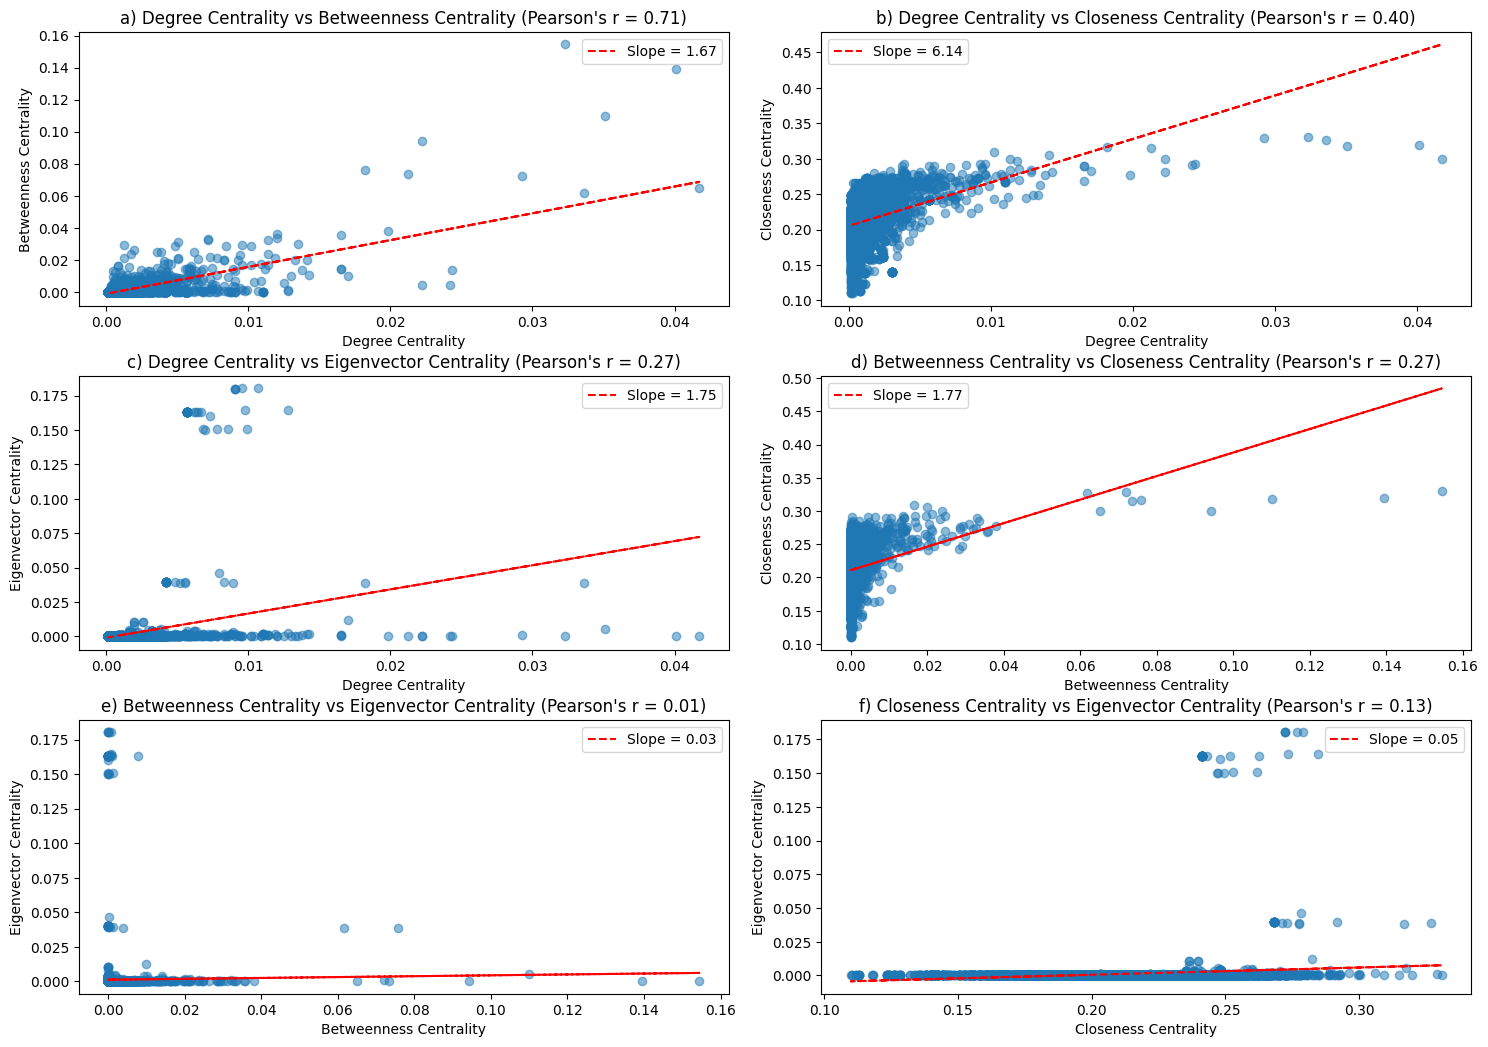

In [14]:
plt.figure(figsize=(15, 12))

degree_values = np.array([degree_centrality[node] for node in adjusted_graph.nodes()])
betweenness_values = np.array([betweenness_centrality[node] for node in adjusted_graph.nodes()])
closeness_values = np.array([closeness_centrality[node] for node in adjusted_graph.nodes()])
eigenvector_values = np.array([eigenvector_centrality[node] for node in adjusted_graph.nodes()])


plot_scatter(degree_values, betweenness_values, "Degree Centrality", "Betweenness Centrality", 321, 'a')
plot_scatter(degree_values, closeness_values, "Degree Centrality", "Closeness Centrality", 322, 'b')
plot_scatter(degree_values, eigenvector_values, "Degree Centrality", "Eigenvector Centrality", 323, 'c')
plot_scatter(betweenness_values, closeness_values, "Betweenness Centrality", "Closeness Centrality", 324, 'd')
plot_scatter(betweenness_values, eigenvector_values, "Betweenness Centrality", "Eigenvector Centrality", 325, 'e')
plot_scatter(closeness_values, eigenvector_values, "Closeness Centrality", "Eigenvector Centrality", 326, 'f')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save the figure before displaying it
plt.savefig(f"{PLOTS_FOLDER}centralitiescomparisons.png", dpi=300)

# Display the plot
plt.show()


ACTOR-ACTOR CONNECTED GRAPH
-----------------------------------------
Number of nodes: 6159
Number of edges: 22390
Network density: 0.0011806854208447454
Global clustering coefficient: 0.3121113434693635
-----------------------------------------
-----------------------------------------
Pearson's r for Degree Centrality (DC) vs Eigenvector Centrality (EC) -> 0.26831783776096924
Null hypothesis: False
Significant difference: True
Pearson's r for Degree Centrality (DC) vs Betweenness Centrality (BC) -> 0.7131876974781715
Null hypothesis: False
Significant difference: True
Pearson's r for Degree Centrality (DC) vs Closeness Centrality (CC) -> 0.3976455521422856
Null hypothesis: False
Significant difference: True
-----------------------------------------
-----------------------------------------
Pearson's r for Eigenvector Centrality (EC) vs Degree Centrality (DC) -> 0.26831783776096924
Null hypothesis: False
Significant difference: True
Pearson's r for Eigenvector Centrality (EC) vs Betwe

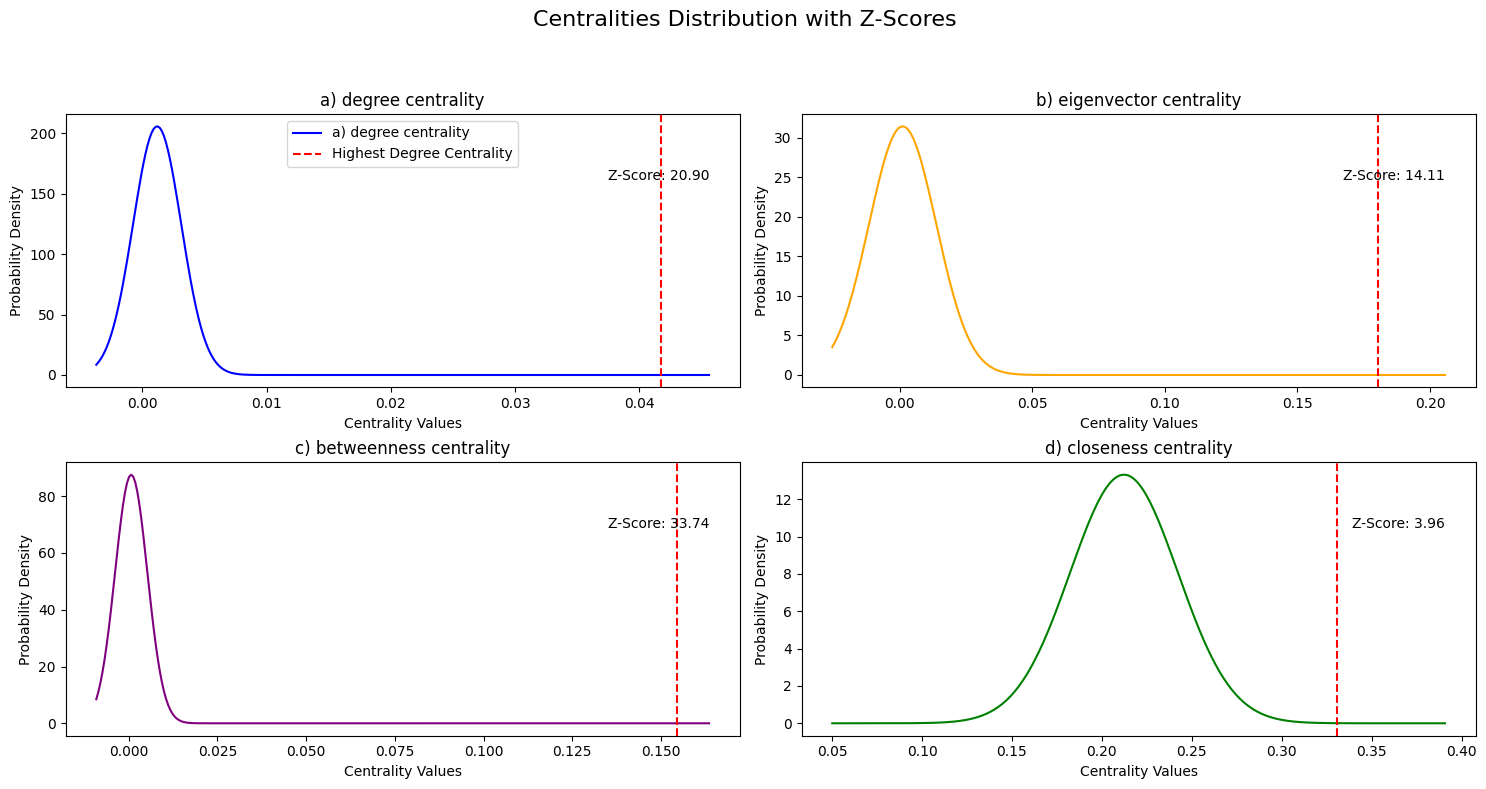

In [22]:
statistics_graph(statistics,adjusted_graph)

In [28]:
# Print top nodes based on centrality measures
topeig = print_top_nodes(eigenvector_centrality, "Eigenvector", adjusted_graph, num_top_nodes=50)
print("\n")
topbet = print_top_nodes(betweenness_centrality, "Betweenness", adjusted_graph, num_top_nodes=50)
print("\n")
topclos = print_top_nodes(closeness_centrality, "Closeness", adjusted_graph, num_top_nodes=50)
print('\n')
topdeg = print_top_nodes(degree_centrality, "Degree", adjusted_graph, num_top_nodes=50)

d0a501c3a44d50246975fc1500d88fd66ba1979f3007a4354b76b0521cec93076d73ec39301502fdf8e9df07ed76af5a4ba7ba3f40f9ed05a160e44eb238466a
ecb72c0bf1dc9799dcf03e415fddd9a7b0bfa9b4acfef0e5cd4ae3e00d6b3be57486a4a9ac98f58cf900db1dd57d189a008d1a88a48304e02cc5e739e3cb9a45
Top 50 nodes based on Eigenvector centrality:
Node       Score      Label               
aa10f...   0.180      Vermeule            
a8566...   0.180      American Journal of Archaeology
39645...   0.180      Adolf Michaelis     
950f1...   0.180      Michaelis           
06a32...   0.165      Gavin Hamilton      
45532...   0.164      Salomon Reinach     
ec288...   0.163      Archäologischer Anzeiger
345df...   0.163      Ann Arbor           
b5697...   0.163      California Private Collection
c541b...   0.163      Georg Lippold       
87aac...   0.163      Whittall Collection 
7115d...   0.163      the Ancient Marbles 
a93d7...   0.163      Greek Sculpture and Roman Taste
fa5de...   0.163      Legendary Hollywood Decorator
cd934..

In [96]:

# Read centrality data from dictionaries
degree_df = read_centrality_data(topdeg)
betweenness_df = read_centrality_data(topbet)
eigenvector_df = read_centrality_data(topeig)
closeness_df = read_centrality_data(topclos)

# Find common nodes
common_nodes = find_common_nodes(closeness_df,degree_df, betweenness_df)

# Create a new DataFrame with common nodes
common_nodes_df = pd.DataFrame({'Label': list(common_nodes)})

# Merge common nodes with each centrality measure with different suffixes
common_nodes_df = pd.merge(common_nodes_df, closeness_df, on='Label').rename(columns={'Score':'Closeness'})
common_nodes_df = pd.merge(common_nodes_df, degree_df, on='Label').rename(columns={'Score':'Degree'})
common_nodes_df = pd.merge(common_nodes_df, betweenness_df, on='Label').rename(columns={'Score':'Betweenness'})

# Order the DataFrame based on Degree Score in descending order
common_nodes_df = common_nodes_df.sort_values(by='Closeness', ascending=False)
common_nodes_df[['Label','Closeness','Degree', 'Betweenness']]

,Label,Closeness,Degree,Betweenness
10,Sotheby Parke-Bernet,0.331,0.032,0.154
1,Royal Athena,0.329,0.029,0.072
12,Parke-Bernet,0.327,0.034,0.062
13,Hôtel Drouot,0.320,0.040,0.139
4,European private collection,0.317,0.035,0.110
15,Spink,0.317,0.018,0.076
14,Bonhams,0.315,0.021,0.073
2,THE DEVOTED CLASSICI THE PRIVATE COLLECTION OF...,0.309,0.010,0.016
5,PROPERTY FROM A NEW YORK CITY PRIVATE COLLECTION,0.306,0.014,0.020
9,Charles Ede,0.300,0.022,0.094
